In [82]:
import pandas as pd
import numpy as np
#import files into DataFrames using pandas and drop duplicate and null values for each file
cabData = pd.read_csv('Cab_Data.csv')
cabData.dropna(subset=cabData.columns, inplace=True)
cabData.drop_duplicates(subset=['Transaction ID'], inplace=True)
cityData = pd.read_csv('City.csv')
cityData.dropna(subset=cityData.columns, inplace=True)
cityData.drop_duplicates(subset=['City'], inplace=True)
customerData = pd.read_csv('Customer_ID.csv')
customerData.dropna(subset=customerData.columns, inplace=True)
customerData.drop_duplicates(subset=['Customer ID'], inplace=True)
transactionData = pd.read_csv('Transaction_ID.csv')
transactionData.dropna(subset=transactionData.columns, inplace=True)
transactionData.drop_duplicates(subset=['Transaction ID'], inplace=True)
#perform merges
transactionData = transactionData.merge(customerData, on="Customer ID", how='left')
cabData = cabData.merge(transactionData, on="Transaction ID", how="left")
#convert numeric columns to proper int format and separate month and year from date to make analysis easier
cityData.loc[:, 'Population'] = cityData['Population'].str.replace(',', '').astype(int)
cityData.loc[:, 'Users'] = cityData['Users'].str.replace(",", "").astype(int)
cabData.loc[:, 'Year'] = cabData['Date of Travel'].str.split("/").str[2]
cabData.loc[:, 'Month'] = cabData['Date of Travel'].str.split("/").str[0]
#remove null rows and duplicate transactions from merged database
cityData.dropna(subset=cityData.columns, inplace=True)
cabData.dropna(subset=cabData.columns, inplace=True)
cabData.drop_duplicates(subset=['Transaction ID'], inplace=True)
#print the data out for reference
print(cabData)
print(cityData)

        Transaction ID Date of Travel     Company           City  \
0             10000011       1/8/2016    Pink Cab     ATLANTA GA   
1             10000012       1/6/2016    Pink Cab     ATLANTA GA   
2             10000013       1/2/2016    Pink Cab     ATLANTA GA   
3             10000014       1/7/2016    Pink Cab     ATLANTA GA   
4             10000015       1/3/2016    Pink Cab     ATLANTA GA   
...                ...            ...         ...            ...   
359387        10440101       1/8/2018  Yellow Cab  WASHINGTON DC   
359388        10440104       1/4/2018  Yellow Cab  WASHINGTON DC   
359389        10440105       1/5/2018  Yellow Cab  WASHINGTON DC   
359390        10440106       1/5/2018  Yellow Cab  WASHINGTON DC   
359391        10440107       1/2/2018  Yellow Cab  WASHINGTON DC   

        KM Travelled  Price Charged  Cost of Trip  Customer ID Payment_Mode  \
0              30.45         370.95      313.6350        29290         Card   
1              28.62     

<Axes: xlabel='KM Travelled', ylabel='Price Charged'>

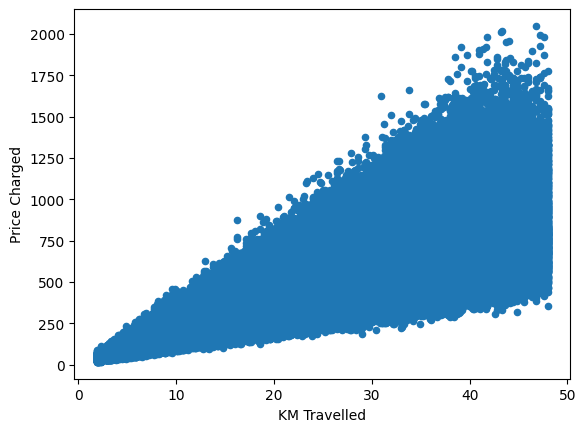

In [83]:
#First establish that the price charged is proportional to the distance traveled
cabData.plot(kind="scatter", x="KM Travelled", y="Price Charged")

<Axes: title={'center': 'Price Charged Vs KM Travelled'}, xlabel='KM Travelled', ylabel='Price Charged'>

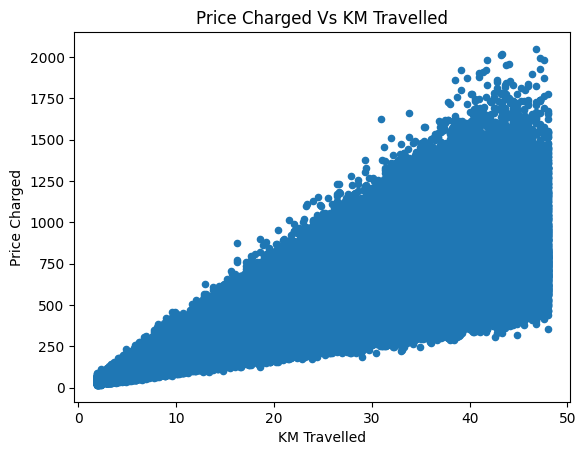

In [84]:
#perform outlier detection based on distance traveled and price charged
firstQ = cabData['KM Travelled'].quantile(.25)
thirdQ = cabData['KM Travelled'].quantile(.75)
iqr = thirdQ - firstQ
priceFirstQ = cabData['Price Charged'].quantile(.25)
priceThirdQ = cabData['Price Charged'].quantile(.75)
priceIQR = priceThirdQ - priceFirstQ
indexesToDrop = []
for i in range(len(cabData['KM Travelled'])):
    if cabData['KM Travelled'][i] < firstQ - 1.5*iqr or cabData['KM Travelled'][i] > thirdQ + 1.5*iqr or cabData['Price Charged'][i] < priceFirstQ - 1.5*priceIQR or cabData['Price Charged'][i] > priceThirdQ + 1.5*priceIQR:
        indexesToDrop += [i]
cabData.drop(indexesToDrop)
cabData.plot(kind="scatter", x="KM Travelled", y="Price Charged", title="Price Charged Vs KM Travelled")

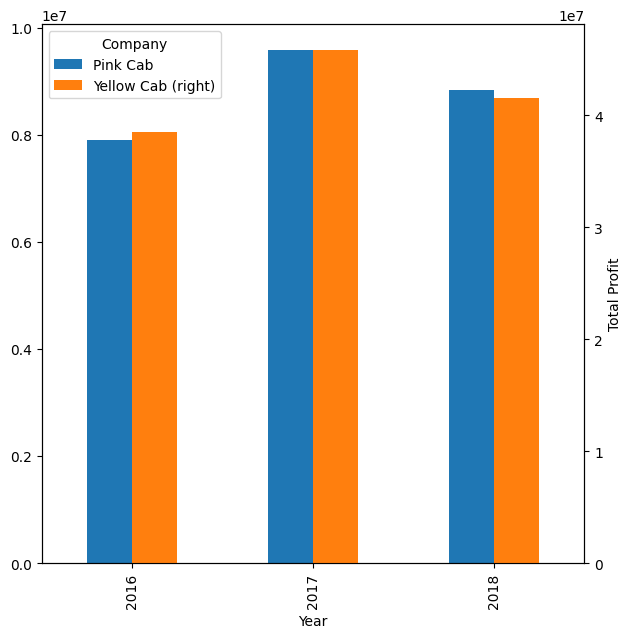

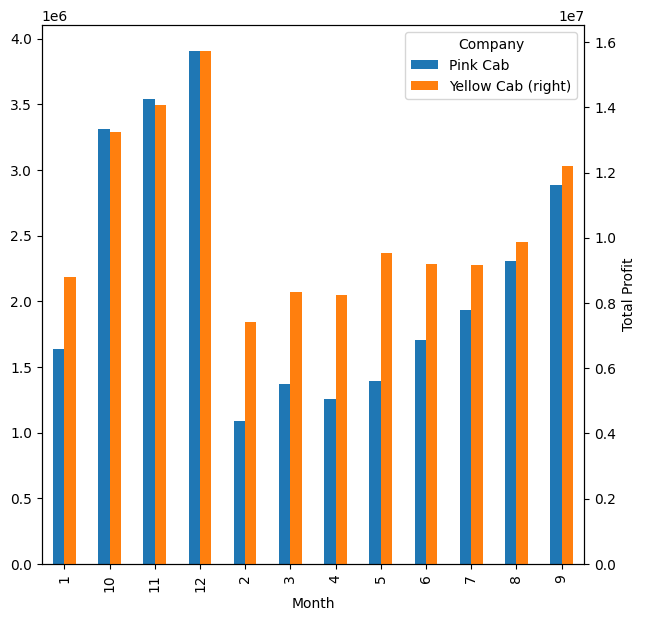

In [91]:
#Which months and which years were the most profitable for each company?
profitYear = cabData.groupby(['Year', 'Company'])['Price Charged'].sum().unstack().plot(kind="bar", ylabel="Total Profit", secondary_y='Yellow Cab', figsize=(7,7))
profitMonth = cabData.groupby(['Month', 'Company'])['Price Charged'].sum().unstack().plot(kind = 'bar', ylabel="Total Profit", secondary_y='Yellow Cab', figsize=(7,7))

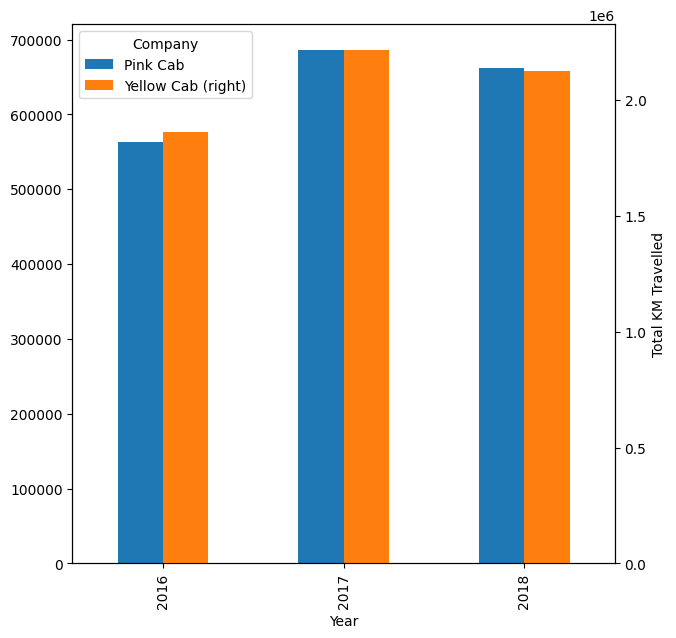

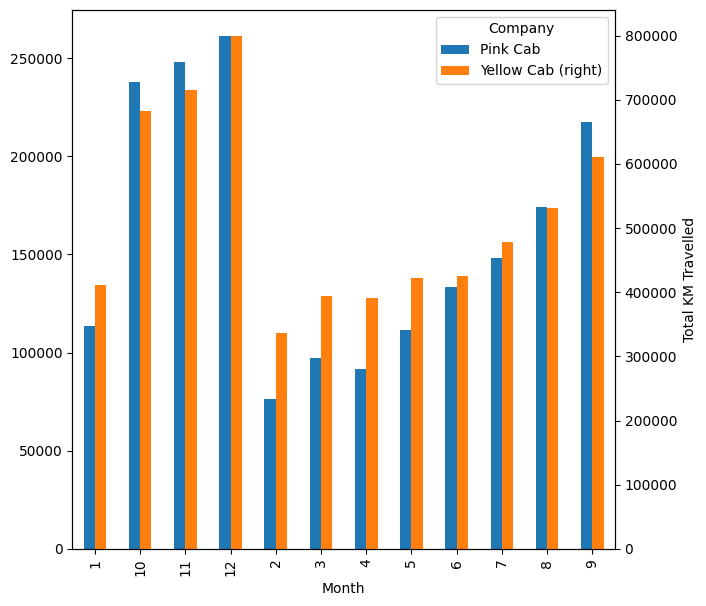

In [86]:
#which years and which months saw the most travel for each company?
travelYear = cabData.groupby(['Year', 'Company'])['KM Travelled'].sum().unstack().plot(kind="bar",ylabel="Total KM Travelled", secondary_y='Yellow Cab', figsize=(7,7))
travelMonth = cabData.groupby(['Month', 'Company'])['KM Travelled'].sum().unstack().plot(kind="bar", ylabel="Total KM Travelled", secondary_y='Yellow Cab', figsize=(7,7))

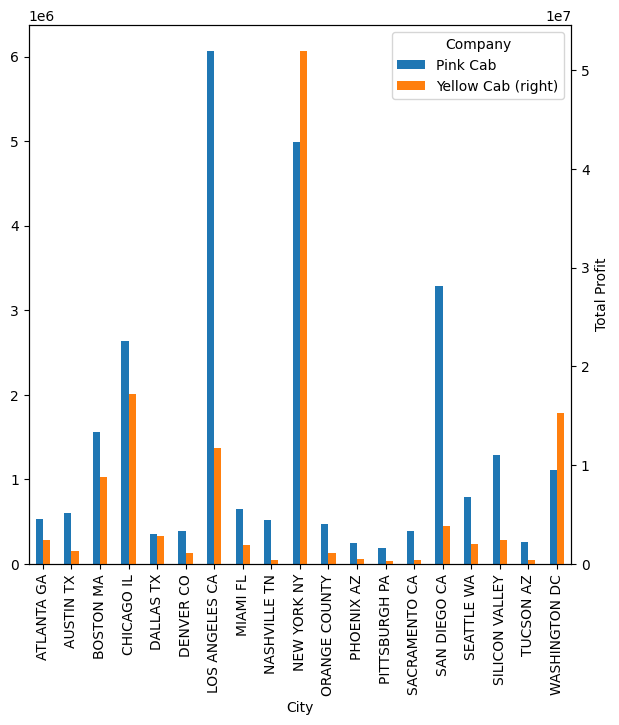

In [92]:
#which cities generate the most profit for each company?
cities = cabData.groupby(['City', 'Company'])['Price Charged'].sum().unstack().plot(kind="bar",ylabel="Total Profit", secondary_y='Yellow Cab', figsize=(7,7))